# Calculo  de las velocidades a partir de GPX
Se calculan las velocidades y se construyen los puntos de velocidades para asignar a la red

## Necesarios
* GPX de los modos de transporte
* librerias instalas en especial Geopandas

In [1]:
#Se importan las librerias necesarias
import gpxpy 
import gpxpy.gpx
import pandas as pd
import numpy as np
import geopandas as gpd
#import movingpandas
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from datetime import datetime, time, date
from os import listdir
import os
import re
from shapely.geometry import Point, LineString
from shapely import wkt
import warnings

#Sequitan los mensajes de error
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#Se construye una ruta
def ls(ruta ="."):
    return listdir(ruta)

In [3]:
#Se coloca la carpeta donde estan los GPX del modo en especial
#ruta="G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/GPX/Carro/"
#ruta="G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/GPX/Moto/"
ruta="G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/GPX/Bici/"
#ruta="G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/GPX/Bici/"
#ruta="G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/GPX/TPC/"
archivos = ls(ruta)

In [4]:
#extraer todos los archivos .gpx de la ruta
gpx_file = [gpx for gpx in archivos if re.findall("gpx$", gpx)]

In [5]:
#Obtener la información de todos los archivos del gps
Latitude = []
Longitude = []
Altitude = []
Time = []
ID = []
File = []
x=-1
for file in gpx_file:
    gpx = gpxpy.parse(open(ruta+file), 'r')
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                Latitude.append(point.latitude)
                Longitude.append(point.longitude)
                Altitude.append(point.elevation)
                Time.append(point.time)
                File.append(file)
                x += 1
                ID.append(x)
                #print('Point',x,'at ({0},{1}) -> {2}, {3}'.format(point.latitude, point.longitude, 
                #                                    point.elevation, point.time))
                
#convertir tiempo y fecha a string
tiempo=[]
fecha=[]
for val in Time:
    tiempo.append(val.strftime("%H:%M:%S"))
    fecha.append(val.strftime("%d-%m-%Y"))


In [6]:
#Eliminar el primer dato
Altitude.pop(0)
Time.pop(0)
ID.pop(0)
tiempo.pop(0)
fecha.pop(0)

'01-01-1970'

In [7]:
#Dataframe con ruta y coordenadas en WGS84
df_dic = {}
df_dic = {
              "latitud":Latitude,
              "longitud":Longitude,
              "file":File,
         }

In [8]:
df = pd.DataFrame(data=df_dic)
df

,latitud,longitud,file
0,4.43877,-75.19160,1969-12-31_19-26_Wed.gpx
1,4.43874,-75.19168,1969-12-31_19-26_Wed.gpx
2,4.43873,-75.19158,1969-12-31_19-26_Wed.gpx
3,4.43871,-75.19157,1969-12-31_19-26_Wed.gpx
4,4.43862,-75.19149,1969-12-31_19-26_Wed.gpx
...,...,...,...
30198,4.43132,-75.20246,Volviendo_.gpx
30199,4.43132,-75.20246,Volviendo_.gpx
30200,4.43131,-75.20247,Volviendo_.gpx
30201,4.43131,-75.20248,Volviendo_.gpx


<AxesSubplot:xlabel='longitud', ylabel='latitud'>

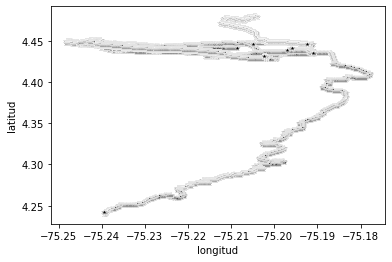

In [9]:
#mapa de puntos
sns.scatterplot(data=df,x="longitud",y="latitud", marker="*", color="0")

#plt.savefig("C:/Users/user/Desktop/Tesis/Figuras/pru1.png", dpi = 100)

In [10]:
#Para obterner el geometry
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitud, df.latitud),crs={"init":"EPSG:4326"})

In [11]:
gdf = gdf.to_crs({"init":"EPSG:3116"})

In [12]:
gdf

,latitud,longitud,file,geometry
0,4.43877,-75.19160,1969-12-31_19-26_Wed.gpx,POINT (876342.058 982684.602)
1,4.43874,-75.19168,1969-12-31_19-26_Wed.gpx,POINT (876332.239 982680.724)
2,4.43873,-75.19158,1969-12-31_19-26_Wed.gpx,POINT (876344.116 982680.142)
3,4.43871,-75.19157,1969-12-31_19-26_Wed.gpx,POINT (876345.322 982677.596)
4,4.43862,-75.19149,1969-12-31_19-26_Wed.gpx,POINT (876353.966 982667.607)
...,...,...,...,...
30198,4.43132,-75.20246,Volviendo_.gpx,POINT (875134.451 981862.386)
30199,4.43132,-75.20246,Volviendo_.gpx,POINT (875134.561 981862.054)
30200,4.43131,-75.20247,Volviendo_.gpx,POINT (875133.783 981861.502)
30201,4.43131,-75.20248,Volviendo_.gpx,POINT (875132.672 981861.061)


In [13]:
Trajectories = []
#Eliminar el primero de route y coordenadas para que los arrays tengan igual len
File.pop(0)
Latitude.pop(0)
Longitude.pop(0)

for i in range(0, len(gdf)-1):
    if  (gdf["file"].iloc[i] == gdf["file"].iloc[i+1]): #Evita leer coordenadas de rutas diferentes
        #Genera el geometry de lineas a partir de los puntos
        Trajectories.append(LineString([gdf.geometry[i], gdf.geometry[i + 1]]).wkt)
    else:
        #Borra los datos de las geometrías sobrantes
        Altitude.pop(i)
        Time.pop(i)
        ID.pop(i)
        tiempo.pop(i)
        fecha.pop(i)
        Latitude.pop(i)
        Longitude.pop(i)
        File.pop(i)

#Generar el nuevo geodataframe de lineas
df1_dic = {}
df1_dic = {
              "ID":ID,
              "latitud":Latitude,
              "longitud":Longitude,
              "altura": Altitude,  
              "fecha":fecha,
              "tiempo":tiempo,
              "timestamp":Time,
              "trajectory":Trajectories,
              "file":File
         }

df1 = pd.DataFrame(data=df1_dic)
df1['trajectory'] = df1['trajectory'].apply(wkt.loads)
gdf2 = gpd.GeoDataFrame(df1, geometry = df1['trajectory'], crs = "EPSG:3116")

In [14]:
gdf2

,ID,latitud,longitud,altura,fecha,tiempo,timestamp,trajectory,file,geometry
0,1,4.43874,-75.19168,1090.18000,01-01-1970,00:26:33,1970-01-01 00:26:33+00:00,LINESTRING (876342.057891006 982684.6023954538...,1969-12-31_19-26_Wed.gpx,"LINESTRING (876342.058 982684.602, 876332.239 ..."
1,2,4.43873,-75.19158,1092.88000,01-01-1970,00:26:35,1970-01-01 00:26:35+00:00,LINESTRING (876332.2388619583 982680.723984823...,1969-12-31_19-26_Wed.gpx,"LINESTRING (876332.239 982680.724, 876344.116 ..."
2,3,4.43871,-75.19157,1084.98000,01-01-1970,00:26:38,1970-01-01 00:26:38+00:00,LINESTRING (876344.1159444287 982680.142038426...,1969-12-31_19-26_Wed.gpx,"LINESTRING (876344.116 982680.142, 876345.322 ..."
3,4,4.43862,-75.19149,1080.38000,01-01-1970,00:26:41,1970-01-01 00:26:41+00:00,LINESTRING (876345.3221107685 982677.596377734...,1969-12-31_19-26_Wed.gpx,"LINESTRING (876345.322 982677.596, 876353.966 ..."
4,5,4.43857,-75.19140,1078.18000,01-01-1970,00:26:43,1970-01-01 00:26:43+00:00,LINESTRING (876353.9657765316 982667.607071674...,1969-12-31_19-26_Wed.gpx,"LINESTRING (876353.966 982667.607, 876363.782 ..."
...,...,...,...,...,...,...,...,...,...,...
30169,30198,4.43132,-75.20246,1130.40000,13-01-2021,00:04:26,2021-01-13 00:04:26+00:00,LINESTRING (875134.2299704738 981863.270964749...,Volviendo_.gpx,"LINESTRING (875134.230 981863.271, 875134.451 ..."
30170,30199,4.43132,-75.20246,1130.40000,13-01-2021,00:04:27,2021-01-13 00:04:27+00:00,LINESTRING (875134.4506484546 981862.385811016...,Volviendo_.gpx,"LINESTRING (875134.451 981862.386, 875134.561 ..."
30171,30200,4.43131,-75.20247,1130.40000,13-01-2021,00:04:28,2021-01-13 00:04:28+00:00,LINESTRING (875134.5611552545 981862.053836260...,Volviendo_.gpx,"LINESTRING (875134.561 981862.054, 875133.783 ..."
30172,30201,4.43131,-75.20248,1130.40000,13-01-2021,00:04:29,2021-01-13 00:04:29+00:00,LINESTRING (875133.7832446671 981861.502004696...,Volviendo_.gpx,"LINESTRING (875133.783 981861.502, 875132.672 ..."


In [15]:
#Obtener T y T0
gdf2["t0"] =0
for i in range(len(gdf2)):
    if (i == 0) or (gdf2["file"].iloc[i] != gdf2["file"].iloc[i-1]):
        gdf2["t0"].loc[i] = gdf2["tiempo"].loc[i]
    else:
        gdf2["t0"].loc[i] = gdf2["tiempo"].loc[i-1]

In [16]:
#Obtener A y A0
gdf2["A0"] =0
for i in range(len(gdf2)):
    if (i == 0) or (gdf2["file"].iloc[i] != gdf2["file"].iloc[i-1]):
        gdf2["A0"].loc[i] = gdf2["altura"].loc[i]
    else:
        gdf2["A0"].loc[i] = gdf2["altura"].loc[i-1]

In [17]:
def calc_velocity(line, time_start, time_end):
    try:
        vel = line.length / (time_end - time_start).seconds
        return vel
    except:
        return 0

In [18]:
def calc_slope(line, a, a0):
    try:
        slope = (a-a0) * 100 / line.length
        return slope
    except:
        return 0

In [19]:
#convertir tiempo a datetime
gdf2["tiempo"] = gdf2["tiempo"].apply(lambda row: datetime.strptime(row,"%H:%M:%S"))
gdf2["t0"]= gdf2["t0"].apply(lambda row: datetime.strptime(row,"%H:%M:%S"))

In [20]:
#calcular velocidades
gdf2['velocity_mps'] = gdf2.apply(
    lambda row: calc_velocity(
        line=row["geometry"],
        time_start=row['t0'],
        time_end=row['tiempo']
    ),
    axis=1
)
gdf2["velocity_kmph"] = (gdf2["velocity_mps"] * 3.6)

In [21]:
#calcular pendiente
gdf2['slope'] = gdf2.apply(
    lambda row: calc_slope(
        line=row["geometry"],
        a=row["altura"],
        a0=row["A0"]
    ),
    axis=1
)

In [22]:
gdf2.drop(columns="trajectory",inplace=True)

sns.boxplot(data=gdf2["velocity_kmph"])

Q3 = np.percentile(gdf2["velocity_kmph"], 75)
Q1 = np.percentile(gdf2["velocity_kmph"], 25)
RIC = Q3 - Q1
Q3, Q1, RIC

LS = Q3 + 1.5*RIC
LS

#Interpolar datos que sobrepasan 44.2 kmps
a=0
polar = 0
gdf2["Int_Vel"] = "No"
for i in gdf2["velocity_kmph"]:
    if gdf2["velocity_kmph"].iloc[a] > LS and a > 0:
        polar += 1
        gdf2["velocity_kmph"].iloc[a] = np.nan
        gdf2["velocity_mps"].iloc[a] = np.nan
        gdf2["Int_Vel"].iloc[a] = "Sí"

    a += 1
gdf2["velocity_kmph"].interpolate(method="linear",inplace=True)
gdf2["velocity_mps"].interpolate(method="linear",inplace=True)
print("Se interpolaron",polar,"velocidades")

sns.boxplot(data=gdf2["velocity_kmph"])

sns.boxplot(data=gdf2["slope"])

Q3 = np.nanpercentile(gdf2["slope"], 75)
Q1 = np.nanpercentile(gdf2["slope"], 25)
RIC = Q3 - Q1
Q3, Q1, RIC

LS = Q3 + 1.5*RIC
LS

LI = Q1 - 1.5*RIC
LI

#Interpolar pendientes grandes
a=0
polar = 0
gdf2["Int_Slope"] = "No"
for i in gdf2["slope"]:
    if (gdf2["slope"].iloc[a] > LS and a > 0) or (gdf2["slope"].iloc[a] < LI and a > 0):
        polar += 1
        gdf2["slope"].iloc[a] = np.nan
        gdf2["Int_Slope"].iloc[a] = "Sí"

    a += 1
gdf2["slope"].interpolate(method="linear",inplace=True)
print("Se interpolaron",polar," pendientes")

sns.boxplot(data=gdf2["slope"])

In [23]:
#Se cambia el formato de la hora y fecha
gdf2["tiempo"] = gdf2["tiempo"].apply(
    lambda row: 
    row.strftime("%H:%M:%S")
    )
gdf2["t0"] = gdf2["t0"].apply(
    lambda row: 
    row.strftime("%H:%M:%S")
    )
gdf2["timestamp"] = gdf2["timestamp"].apply(
    lambda row: 
    row.strftime("%Y-%m-%d %H:%M:%S")
    )

In [24]:
#Se visualiza la tabla
gdf2

,ID,latitud,longitud,altura,fecha,tiempo,timestamp,file,geometry,t0,A0,velocity_mps,velocity_kmph,slope
0,1,4.43874,-75.19168,1090.18000,01-01-1970,00:26:33,1970-01-01 00:26:33,1969-12-31_19-26_Wed.gpx,"LINESTRING (876342.058 982684.602, 876332.239 ...",00:26:33,1090.18000,0.00000,0.00000,0.00000
1,2,4.43873,-75.19158,1092.88000,01-01-1970,00:26:35,1970-01-01 00:26:35,1969-12-31_19-26_Wed.gpx,"LINESTRING (876332.239 982680.724, 876344.116 ...",00:26:33,1090.18000,5.94567,21.40440,22.70562
2,3,4.43871,-75.19157,1084.98000,01-01-1970,00:26:38,1970-01-01 00:26:38,1969-12-31_19-26_Wed.gpx,"LINESTRING (876344.116 982680.142, 876345.322 ...",00:26:35,1092.88000,0.93898,3.38034,-280.44484
3,4,4.43862,-75.19149,1080.38000,01-01-1970,00:26:41,1970-01-01 00:26:41,1969-12-31_19-26_Wed.gpx,"LINESTRING (876345.322 982677.596, 876353.966 ...",00:26:38,1084.98000,4.40327,15.85178,-34.82259
4,5,4.43857,-75.19140,1078.18000,01-01-1970,00:26:43,1970-01-01 00:26:43,1969-12-31_19-26_Wed.gpx,"LINESTRING (876353.966 982667.607, 876363.782 ...",00:26:41,1080.38000,5.64505,20.32219,-19.48608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30169,30198,4.43132,-75.20246,1130.40000,13-01-2021,00:04:26,2021-01-13 00:04:26,Volviendo_.gpx,"LINESTRING (875134.230 981863.271, 875134.451 ...",00:04:25,1130.30000,0.91225,3.28409,10.96193
30170,30199,4.43132,-75.20246,1130.40000,13-01-2021,00:04:27,2021-01-13 00:04:27,Volviendo_.gpx,"LINESTRING (875134.451 981862.386, 875134.561 ...",00:04:26,1130.40000,0.34988,1.25958,0.00000
30171,30200,4.43131,-75.20247,1130.40000,13-01-2021,00:04:28,2021-01-13 00:04:28,Volviendo_.gpx,"LINESTRING (875134.561 981862.054, 875133.783 ...",00:04:27,1130.40000,0.95376,3.43355,0.00000
30172,30201,4.43131,-75.20248,1130.40000,13-01-2021,00:04:29,2021-01-13 00:04:29,Volviendo_.gpx,"LINESTRING (875133.783 981861.502, 875132.672 ...",00:04:28,1130.40000,1.19501,4.30205,0.00000


(974740.0, 992760.0)

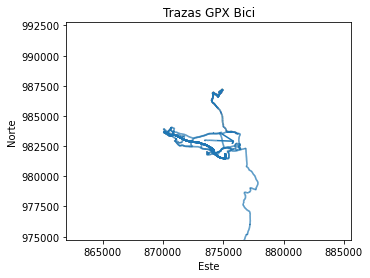

In [25]:
#Se grafican las lineas
gdf2.plot()
plt.xlabel('Este')
plt.ylabel('Norte')
plt.title('Trazas GPX Bici')
# Set axes

plt.xlim(862000, 885600)
plt.ylim(974740, 992760)

#plt.plot([865000, 870000, 875000, 880000, 885000], [975000, 977500, 980000, 982500, 985000, 987500, 990000, 992500])
#plt.savefig("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/Articulo/Graficas/GPX/Bici.png", dpi = 300)

In [26]:
# copy poly to new GeoDataFrame
points = gdf2.copy()
# change the geometry
points.geometry = points['geometry'].centroid
# same crs
points.crs = gdf2.crs
points

,ID,latitud,longitud,altura,fecha,tiempo,timestamp,file,geometry,t0,A0,velocity_mps,velocity_kmph,slope
0,1,4.43874,-75.19168,1090.18000,01-01-1970,00:26:33,1970-01-01 00:26:33,1969-12-31_19-26_Wed.gpx,POINT (876337.148 982682.663),00:26:33,1090.18000,0.00000,0.00000,0.00000
1,2,4.43873,-75.19158,1092.88000,01-01-1970,00:26:35,1970-01-01 00:26:35,1969-12-31_19-26_Wed.gpx,POINT (876338.177 982680.433),00:26:33,1090.18000,5.94567,21.40440,22.70562
2,3,4.43871,-75.19157,1084.98000,01-01-1970,00:26:38,1970-01-01 00:26:38,1969-12-31_19-26_Wed.gpx,POINT (876344.719 982678.869),00:26:35,1092.88000,0.93898,3.38034,-280.44484
3,4,4.43862,-75.19149,1080.38000,01-01-1970,00:26:41,1970-01-01 00:26:41,1969-12-31_19-26_Wed.gpx,POINT (876349.644 982672.602),00:26:38,1084.98000,4.40327,15.85178,-34.82259
4,5,4.43857,-75.19140,1078.18000,01-01-1970,00:26:43,1970-01-01 00:26:43,1969-12-31_19-26_Wed.gpx,POINT (876358.874 982664.818),00:26:41,1080.38000,5.64505,20.32219,-19.48608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30169,30198,4.43132,-75.20246,1130.40000,13-01-2021,00:04:26,2021-01-13 00:04:26,Volviendo_.gpx,POINT (875134.340 981862.828),00:04:25,1130.30000,0.91225,3.28409,10.96193
30170,30199,4.43132,-75.20246,1130.40000,13-01-2021,00:04:27,2021-01-13 00:04:27,Volviendo_.gpx,POINT (875134.506 981862.220),00:04:26,1130.40000,0.34988,1.25958,0.00000
30171,30200,4.43131,-75.20247,1130.40000,13-01-2021,00:04:28,2021-01-13 00:04:28,Volviendo_.gpx,POINT (875134.172 981861.778),00:04:27,1130.40000,0.95376,3.43355,0.00000
30172,30201,4.43131,-75.20248,1130.40000,13-01-2021,00:04:29,2021-01-13 00:04:29,Volviendo_.gpx,POINT (875133.228 981861.282),00:04:28,1130.40000,1.19501,4.30205,0.00000


<AxesSubplot:>

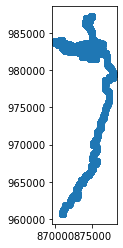

In [27]:
#Se grafican los puntos
points.plot()

In [28]:
#Se guarda el Shape
#points.to_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/PuntosVelocidades/p_vel_orig/Carro.shp")
#points.to_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/PuntosVelocidades/p_vel_orig/Moto.shp")
points.to_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/PuntosVelocidades/p_vel_orig/Bici2.shp")
#points.to_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/PuntosVelocidades/p_vel_orig/TPC.shp")

Se pasa al codigo 01-outlayers-velocidades.ipynb  en el que se asigna el promedio de las velocidades a os links